In [47]:
import pandas as pd
import numpy as np
import networkx as nx
from datetime import datetime
from collections import Counter
import time

import stellargraph as sg
from stellargraph import StellarGraph
from sklearn.preprocessing import OrdinalEncoder
from stellargraph.data import EdgeSplitter
from stellargraph.mapper import FullBatchLinkGenerator
from stellargraph.layer import GCN, LinkEmbedding
from stellargraph import globalvar
from stellargraph import datasets
from stellargraph.mapper import GraphSAGELinkGenerator
from stellargraph.layer import GraphSAGE, link_classification
from stellargraph.data import UniformRandomWalk
from stellargraph.data import UnsupervisedSampler

from tensorflow import keras
from sklearn import preprocessing, feature_extraction, model_selection

from IPython.display import display, HTML
%matplotlib inline

In [48]:
def build_graph(graph,data):
    pr_id_list = data['pr_id'].unique()
    for pr_id in pr_id_list:
        pr_owner_set, reviewer_set = get_node_ids(pr_id, data)

        for pr_owner_id in pr_owner_set:
            if not graph.has_node(pr_owner_id):
                user_info = node_info(pr_owner_id, data)
                graph.add_node(pr_owner_id, **user_info)

            for reviewer_id in reviewer_set:
                if not graph.has_node(reviewer_id):
                    user_info = node_info(reviewer_id, data)
                    graph.add_node(reviewer_id, **user_info)
                
                if not graph.has_edge(pr_owner_id, reviewer_id):
                    weight = get_edge_weight(pr_owner_id, reviewer_id, data)
                    graph.add_edge(pr_owner_id, reviewer_id, weight=weight)

    return graph

def get_edge_weight(pr_owner_id, reviewer_id, data):
    df = data[(data['commenter_id']==reviewer_id) & \
        ((data['head_commit_author_id']==pr_owner_id) | (data['head_commit_committer_id']==pr_owner_id))]
    
    comment_times = df['comment_created_at'].map(convert_to_tic)
    df['weight'] = comment_times
    df = df.sort_values(by='weight')

    decay = 0.8
    counts = Counter()
    for index, row in df.iterrows():
        row['weight'] *= decay**counts[(row['pr_id'], row['commenter_id'])]
        counts[(row['pr_id'], row['commenter_id'])] += 1

    weight = df['weight'].sum()
    return weight

def get_node_ids(pr_id, data):
    pr_df = data.loc[data.pr_id == pr_id, :]
    commenter_set = set(pr_df.commenter_id.values)
    head_commiter_set = set(pr_df.head_commit_committer_id.values)
    head_author_set = set(pr_df.head_commit_author_id.values)
    pr_owner_set = (head_author_set | head_commiter_set) & commenter_set
    reviewer_set = commenter_set - pr_owner_set
    return pr_owner_set, reviewer_set

def create_features(info_dict):
    features = {}
    features["features"] = list(info_dict.values())
    return features
    
def node_info(target, data):
    info_cols = ['commenter_username_enc', 'commenter_follower_count',
                        'commenter_total_github_commit_count', 'commenter_base_repo_commit_count']
    info_dict = data.loc[(data.commenter_id == target), info_cols].iloc[0].to_dict()
    info_dict = create_features(info_dict)
    return info_dict

def convert_to_tic(s):
    #Jan, 1, 2014
    start_time = time.mktime(datetime(2014, 1, 1).timetuple())
    #Jan, 1, 2019
    end_time = time.mktime(datetime(2019, 1, 1).timetuple())
    time_delta = end_time-start_time
    return float(time.mktime(pd.to_datetime(s).timetuple()) - start_time) / time_delta

In [49]:
def prepare_inputs(data):
    oe = OrdinalEncoder()
    oe.fit(data)
    data_enc = oe.transform(data)
    return data_enc

In [50]:
user_graph = nx.Graph()
data = pd.read_csv('pr_comments_with_commenter_stat.csv')
d = prepare_inputs(data[['commenter_username']])
data['commenter_username_enc'] = d
user_graph = build_graph(user_graph, data)

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [51]:
user_stellar = StellarGraph.from_networkx(user_graph, node_features = 'features')

In [52]:
edge_splitter_test = EdgeSplitter(user_stellar)

G_test, edge_ids_test, edge_labels_test = edge_splitter_test.train_test_split(
    p=0.1, method="global", keep_connected=True
)

** Sampled 465 positive and 465 negative edges. **


In [53]:
edge_splitter_train = EdgeSplitter(G_test)

G_train, edge_ids_train, edge_labels_train = edge_splitter_train.train_test_split(
    p=0.1, method="global", keep_connected=True
)

** Sampled 419 positive and 419 negative edges. **


In [54]:
print(G_train.info())

StellarGraph: Undirected multigraph
 Nodes: 1059, Edges: 3773

 Node types:
  default: [1059]
    Features: float32 vector, length 4
    Edge types: default-default->default

 Edge types:
    default-default->default: [3773]
        Weights: range=[0.0314172, 340.128], mean=5.15914, std=14.9686
        Features: none


In [55]:
print(G_test.info())

StellarGraph: Undirected multigraph
 Nodes: 1059, Edges: 4192

 Node types:
  default: [1059]
    Features: float32 vector, length 4
    Edge types: default-default->default

 Edge types:
    default-default->default: [4192]
        Weights: range=[0.0314172, 340.128], mean=5.33759, std=14.8773
        Features: none


In [56]:
batch_size = 20
epochs = 20

In [57]:
num_samples = [20, 10]

In [58]:
train_gen = GraphSAGELinkGenerator(G_train, batch_size, num_samples)
train_flow = train_gen.flow(edge_ids_train, edge_labels_train, shuffle=True)

In [59]:
test_gen = GraphSAGELinkGenerator(G_test, batch_size, num_samples)
test_flow = test_gen.flow(edge_ids_test, edge_labels_test)

In [60]:
layer_sizes = [20, 20]
graphsage = GraphSAGE(
    layer_sizes=layer_sizes, generator=train_gen, bias=True, dropout=0.3
)

In [61]:
x_inp, x_out = graphsage.in_out_tensors()

In [62]:
prediction = link_classification(
    output_dim=1, output_act="relu", edge_embedding_method="ip"
)(x_out)

link_classification: using 'ip' method to combine node embeddings into edge embeddings


In [63]:
model = keras.Model(inputs=x_inp, outputs=prediction)

model.compile(
    optimizer=keras.optimizers.Adam(lr=1e-3),
    loss=keras.losses.binary_crossentropy,
    metrics=["acc"],
)

In [64]:
init_train_metrics = model.evaluate(train_flow)
init_test_metrics = model.evaluate(test_flow)

print("\nTrain Set Metrics of the initial (untrained) model:")
for name, val in zip(model.metrics_names, init_train_metrics):
    print("\t{}: {:0.4f}".format(name, val))

print("\nTest Set Metrics of the initial (untrained) model:")
for name, val in zip(model.metrics_names, init_test_metrics):
    print("\t{}: {:0.4f}".format(name, val))

47/47 [==============================] - 1s 23ms/step - loss: 1.1134 - acc: 0.4968

Train Set Metrics of the initial (untrained) model:
	loss: 1.1042
	acc: 0.5251

Test Set Metrics of the initial (untrained) model:
	loss: 1.1134
	acc: 0.4968


Train the model:

In [65]:
history = model.fit(train_flow, epochs=epochs, validation_data=test_flow, verbose=2)

Epoch 1/20
42/42 - 2s - loss: 1.2925 - acc: 0.4296 - val_loss: 1.1142 - val_acc: 0.5280
Epoch 2/20
42/42 - 2s - loss: 0.9820 - acc: 0.4952 - val_loss: 1.0672 - val_acc: 0.5280
Epoch 3/20
42/42 - 2s - loss: 0.9472 - acc: 0.5203 - val_loss: 1.0540 - val_acc: 0.5258
Epoch 4/20
42/42 - 2s - loss: 0.9408 - acc: 0.5418 - val_loss: 0.9855 - val_acc: 0.5312
Epoch 5/20
42/42 - 2s - loss: 0.9361 - acc: 0.5107 - val_loss: 1.0141 - val_acc: 0.5247
Epoch 6/20
42/42 - 2s - loss: 0.8791 - acc: 0.5453 - val_loss: 1.0481 - val_acc: 0.5204
Epoch 7/20
42/42 - 2s - loss: 0.8590 - acc: 0.5286 - val_loss: 1.0118 - val_acc: 0.5226
Epoch 8/20
42/42 - 2s - loss: 0.7659 - acc: 0.5764 - val_loss: 0.9738 - val_acc: 0.5333
Epoch 9/20
42/42 - 2s - loss: 0.7659 - acc: 0.5644 - val_loss: 0.9449 - val_acc: 0.5387
Epoch 10/20
42/42 - 2s - loss: 0.7726 - acc: 0.5453 - val_loss: 0.9313 - val_acc: 0.5301
Epoch 11/20
42/42 - 2s - loss: 0.7507 - acc: 0.5513 - val_loss: 0.9071 - val_acc: 0.5484
Epoch 12/20
42/42 - 2s - loss:

Plot the training history:

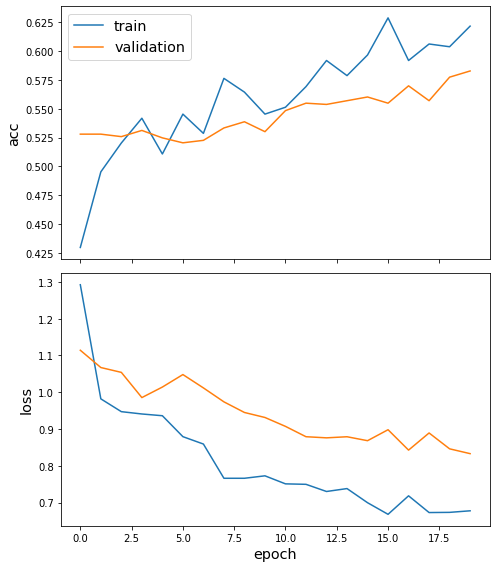

In [66]:
sg.utils.plot_history(history)

Evaluate the trained model on test citation links:

In [67]:
train_metrics = model.evaluate(train_flow)
test_metrics = model.evaluate(test_flow)

print("\nTrain Set Metrics of the trained model:")
for name, val in zip(model.metrics_names, train_metrics):
    print("\t{}: {:0.4f}".format(name, val))

print("\nTest Set Metrics of the trained model:")
for name, val in zip(model.metrics_names, test_metrics):
    print("\t{}: {:0.4f}".format(name, val))

47/47 [==============================] - 1s 23ms/step - loss: 0.8392 - acc: 0.5731

Train Set Metrics of the trained model:
	loss: 0.8094
	acc: 0.5847

Test Set Metrics of the trained model:
	loss: 0.8392
	acc: 0.5731
